In [3]:
import pandas as pd
import scipy.io as sio
from scipy.io import savemat, loadmat
from EEG_pareidolia_utils import get_pareidolia_bids, reformat_events
from biotuner_utils import *
from biotuner_offline import *
from biotuner import *
import pyACA
import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio

In [420]:
def computeFeatureCl(afAudioData, cFeatureName, f_s, bPlotOutput = False):

    # read audio file
    #[f_s, afAudioData] = ToolReadAudio(cPath)
    
    # for debugging
    #afAudioData = np.sin(2*np.pi * np.arange(f_s*1)*440./f_s)

    # compute feature
    [v, t] = pyACA.computeFeature(cFeatureName, afAudioData, f_s, None, 1024, 256)

    # plot feature output
    if bPlotOutput:
        plt.plot(t, v)

    return (v, t)

In [229]:
FOLDERPATH = r'E:\PhD\EEG_data\Pareidolia_BIDS'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 20],[20, 30], [30, 45], [45, 60]]
FREQ_NAMES = ['delta', 'theta', 'alpha', 'low-beta', 'high-beta', 'gamma1', 'gamma2']
RUN_LIST = {'pareidolia':['1', '2', '3', '4']}
SUBJ_LIST = ['01']
TASK_LIST = ['pareidolia']
frontal_L = ['E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E12', 'E18', 'E19', 'E11', 'E15', 'E16']
frontal_R = ['E2', 'E3', 'E4', 'E5', 'E118', 'E124', 'E123', 'E9', 'E10', 'E14', 'E11', 'E15', 'E16']
frontal_LR = frontal_L+frontal_R
occi_R = ['E76', 'E83', 'E84']
occi_L = ['E66', 'E70', 'E71']
test_elec = ['E76']

In [400]:
epochs = mne.read_epochs('../../pareidolia_run2.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading ../../pareidolia_run2.fif ...


<ipython-input-400-6da6241b8dad>:1: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('../../pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


In [446]:
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
condition = par
chs = frontal_R

In [447]:
eeg_data = epochs[condition].average(chs)
eeg_data = np.average(eeg_data.data, axis = 0)
eeg_data = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (-1, +1))
eeg_data

array([ 0.42158137,  0.49011003,  0.45244452, ..., -0.29742728,
       -0.27716022, -0.16897218])

## Empirical Mode Decomposition

0.4549994468688965


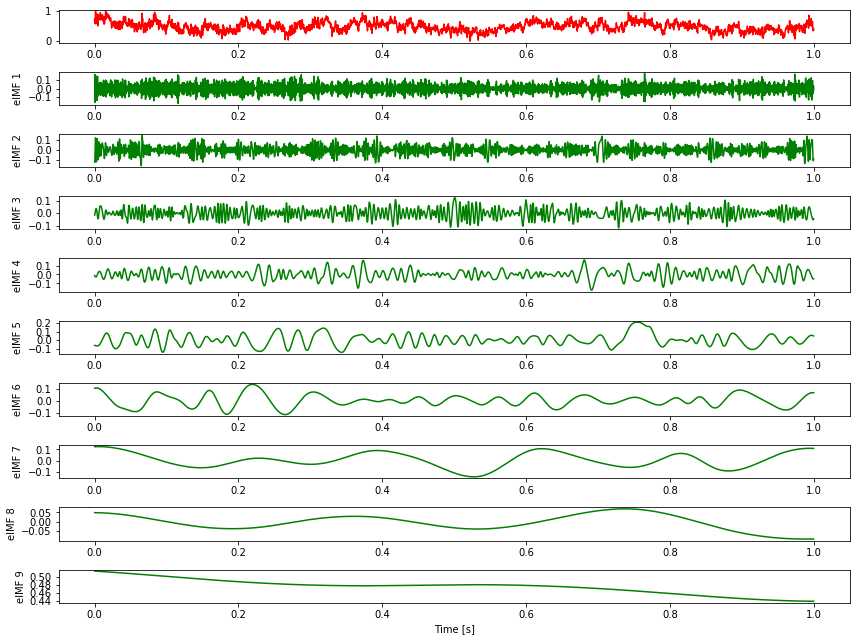

In [448]:
from PyEMD import EMD, EEMD
import numpy as np
s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
eemd = EEMD()
#s = np.random.random(1001)

S = s
t = np.linspace(0, 1, 7001)
# Say we want detect extrema using parabolic method
import time
start = time.time()
emd = eemd.EMD
emd.extrema_detection="parabol"
eIMFs = EMD().emd(s,t)
#eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
stop = time.time()
print(stop-start)
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()

## Plot of spectral features across EMDs

In [455]:

df = pd.DataFrame()
i = 0
for e in eIMFs:
    i +=1
    [f,t] = computeFeatureCl(e, "SpectralCentroid", 1000)
    df[i] = np.squeeze(f)


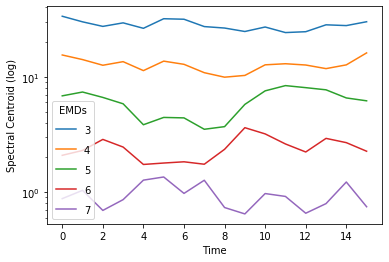

In [456]:
import seaborn as sbn
ax = sbn.lineplot(data=df.loc[0:15, 3:7], dashes = False)
ax.set(xlabel='Time', ylabel='Spectral Centroid (log)')
ax.set_yscale('log')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'lower left')
plt.savefig('EMDs_spectral_flux_par_frontalR', dpi=120)

In [268]:
a= pyACA.computeKey(eeg_data,  1000)
a

'F Maj'

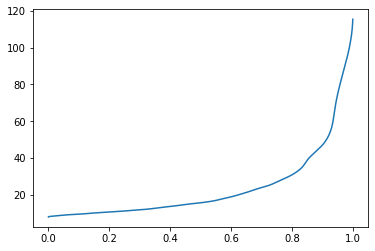

In [412]:
[T,beats] = pyACA.computeBeatHisto(eeg_data, 1000)
plt.plot(T,np.squeeze(beats))

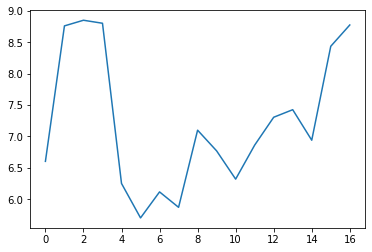

In [413]:
[v,t] = computeFeatureCl(IMF4, "SpectralCentroid", 1000)
v = np.squeeze(v)
plt.plot(v[0:17])

In [329]:
[f,t] = computeFeatureCl(eeg_data, "SpectralFlux", 1000)
pitch_chroma = pd.DataFrame(f)

In [475]:
##Plot of pitch tracking across EMDs###
df = pd.DataFrame()
i = 0
for e in eIMFs:
    i +=1
    [f, t] = pyACA.computePitch('TimeAcf', e, 1000, afWindow=None, iBlockLength=2048, iHopLength=512)
    df[i] = f

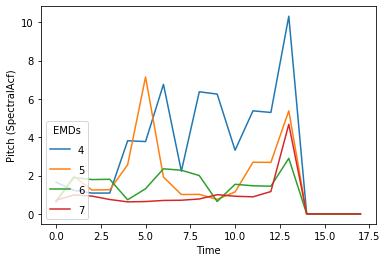

In [476]:
import seaborn as sbn
ax = sbn.lineplot(data=df.loc[0:65, 4:7], dashes = False)
ax.set(xlabel='Time', ylabel='Pitch (SpectralAcf)')
ax.set_yscale('linear')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'lower left')
plt.savefig('EMDs_pitch_par_frontalR', dpi=120)

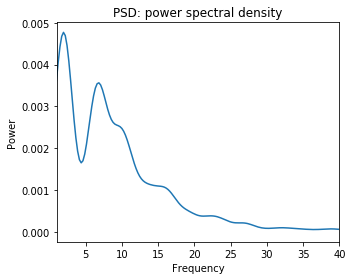

In [259]:
##plot PowerSpectralPlot of each EMD##
freqs, psd = signal.welch(eeg_data, 1000, nfft = 4096, nperseg = 512)
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd)
plt.xlim([1, 40])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

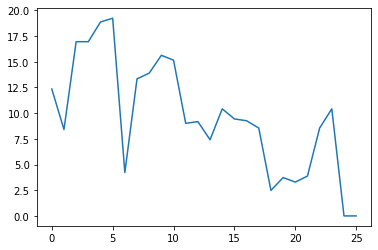

In [147]:
[f, t] = pyACA.computePitch('TimeAcf', IMF3, 1000, afWindow=None, iBlockLength=512, iHopLength=256)
plt.plot(np.squeeze(f))

0.3559536933898926


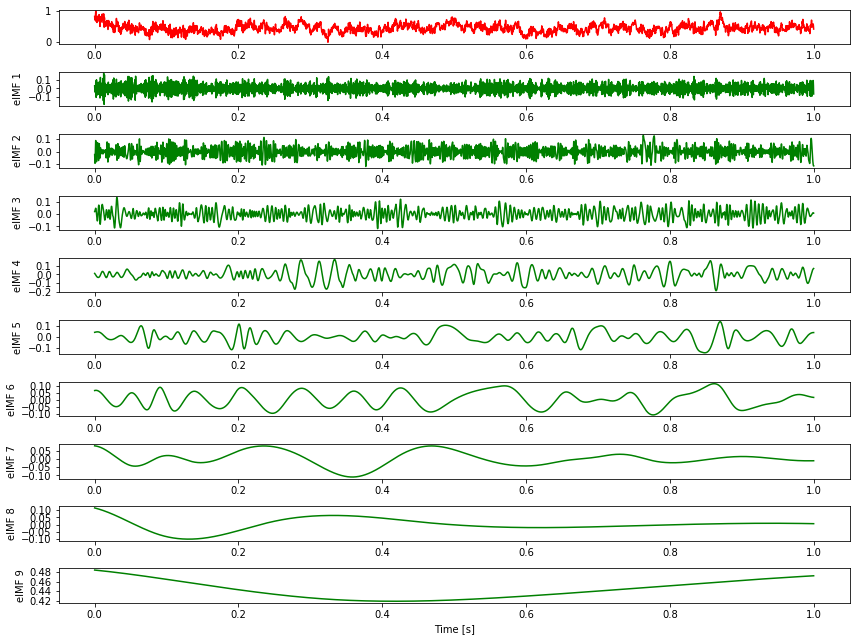

In [128]:
eIMFs.shape
IMF0 = eIMFs[0][0:6000]
IMF1 = eIMFs[1][0:6000]
IMF2 = eIMFs[2][0:6000]
IMF3 = eIMFs[3][0:6000]
IMF4 = eIMFs[4][0:6000]
IMF5 = eIMFs[5][0:6000]
IMF6 = eIMFs[6][0:6000]
IMF7 = eIMFs[7][0:6000]
IMF8 = eIMFs[8][0:6000]
IMF9 = eIMFs[9][0:6000]